## 0. Modules and Custom Functions

In [33]:
from logging import getLogger

from datetime import datetime as dt
from numpy import nan
from pandas import Categorical, DataFrame, read_csv, cut

from matplotlib.pyplot import plot
from matplotlib.pyplot import style, rcParams

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, plot_roc_curve

In [2]:
logger = getLogger("log-reg").setLevel("INFO")

In [3]:
style.use("ggplot")
ggcolors = rcParams['axes.prop_cycle'].by_key()['color']
rcParams["figure.figsize"] = (18, 8)

In [4]:
def get_features(df):
    
    numerical = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical = df.select_dtypes(include=["object", "category"]).columns.tolist()
    dates = df.select_dtypes(include=["datetime", "datetime64[ns]"]).columns.tolist()
    other = df.columns.difference(numerical + categorical + dates).tolist()
    
    return numerical, categorical, dates, other

In [5]:
def get_women_marital_status(gender, title):
    if (gender == "female") and (title in ["mrs", "ms"]):
        marital_status = "married"
    elif gender == "male":
        marital_status = "missing"
    else:
        marital_status = "not_married"
    return marital_status
    

## 1. Get Data

In [6]:
data = read_csv("../data/raw/train.csv")
data = data.rename(columns=dict(zip(data.columns, data.columns.str.lower())))
data = data.set_index("passengerid")

In [7]:
numerical, categorical, dates, other = get_features(data.drop("survived", axis=1, inplace=False))

## 2. Data Transformation

In [8]:
def create_category_features(df):
    df_aux = df.copy()
    
    df_aux.loc[:, "pclass"] = Categorical(
        df_aux["pclass"].map({3:"low", 2:"mid", 1:"high"}), 
        categories=["low", "mid", "high"], 
        ordered=True
        )
    
    df_aux.loc[:, "age_group"] = cut(df_aux["age"], range(0, 90, 10))
    df_aux.loc[:, "fare_group"] = cut(df_aux["fare"], list(range(0, 300, 50)) + [999999], include_lowest=True, right=False)
    
    return df_aux


def create_title_features(df):
    df_aux = df.copy()
    
    lastname_removed = df_aux["name"].str.split(",").apply(lambda x: x[1])
    title = lastname_removed.str.split(".").apply(lambda x: x[0])
    clean_title = title.str.lower().str.strip()
    
    df_aux.loc[:, "title"] = clean_title.apply(lambda t: "other" if t not in ["mr", "mrs", "ms", "miss"] else t)
    df_aux.loc[:, "married_female"] = df_aux.apply(lambda x: get_women_marital_status(x["sex"], x["title"]), axis=1)
    
    return df_aux


def create_ticket_features(df):
    
    df_aux = df.copy()
    
    df_aux["travel_alone"] = (~df_aux.duplicated(subset=['ticket'], keep=False)).map({True:"alone", False:"accompanied"})
    
    return df_aux


def create_adult_features(df):
    
    df_aux = df.copy()
    
    df_aux["adult"] = nan
    df_aux.loc[~df_aux["age"].isna(), "adult"] = df_aux["age"][~df_aux["age"].isna()].apply(lambda x: 18 < x).copy()
    df_aux["adult"] = df_aux["adult"].map({True: "adult", False: "child"}).fillna("missing")
    
    return df_aux

In [9]:
get_categories = FunctionTransformer(create_category_features, validate=False)
get_titles = FunctionTransformer(create_title_features, validate=False)
get_tickets = FunctionTransformer(create_ticket_features, validate=False)
get_adults = FunctionTransformer(create_adult_features, validate=False)

## 3. Missing Data Imputation

In [10]:
def impute_missing_values(df, cats, nums):
    df_aux = df.copy()
    
    categorical_imputer = SimpleImputer(strategy="constant", fill_value="missing")
    numerical_imputer = SimpleImputer(strategy="median")
    
    for cat in cats:
        df_aux[cat] = categorical_imputer.fit_transform(df[cat].to_numpy().reshape(-1, 1))
        
    for num in nums:
        df_aux[num] = numerical_imputer.fit_transform(df[num].to_numpy().reshape(-1, 1))
        
    return df_aux

In [11]:
impute_missing = FunctionTransformer(
    impute_missing_values, 
    validate=False,
    kw_args={"nums": ["age", "fare"], "cats": ["embarked"]}
    )

## 4. Encoding and Scaling

In [12]:
encoders = make_column_transformer(
    (
        OneHotEncoder(handle_unknown="ignore", sparse=False),
        [
            "pclass", "name", "sex", "cabin", "embarked", "age_group", 
            "fare_group", "title", "married_female", "travel_alone", "adult"
            ]
        ), 
    (StandardScaler(), ["age", "sibsp", "parch", "fare"])
    , remainder='drop'
    )

## 5. Model Training

In [13]:
model = LogisticRegression(C=5.0, solver="liblinear", max_iter=1000)

In [17]:
pipe = Pipeline(steps=[
    ("impute", impute_missing),
    ("categories", get_categories),
    ("titles", get_titles),
    ("tickets", get_tickets),
    ("ages", get_adults), 
    ("encoders", encoders),
    ("model", model)
], verbose=True)

In [18]:
df_model = data.copy()

X = df_model[numerical + categorical]
y = df_model["survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [19]:
pipe.fit(X_train, y_train)

[Pipeline] ............ (step 1 of 7) Processing impute, total=   0.0s
[Pipeline] ........ (step 2 of 7) Processing categories, total=   0.0s
[Pipeline] ............ (step 3 of 7) Processing titles, total=   0.0s
[Pipeline] ........... (step 4 of 7) Processing tickets, total=   0.0s
[Pipeline] .............. (step 5 of 7) Processing ages, total=   0.0s
[Pipeline] .......... (step 6 of 7) Processing encoders, total=   0.0s
[Pipeline] ............. (step 7 of 7) Processing model, total=   0.0s


Pipeline(steps=[('impute',
                 FunctionTransformer(func=<function impute_missing_values at 0x7fc591262700>,
                                     kw_args={'cats': ['embarked'],
                                              'nums': ['age', 'fare']})),
                ('categories',
                 FunctionTransformer(func=<function create_category_features at 0x7fc591262940>)),
                ('titles',
                 FunctionTransformer(func=<function create_title_features at 0x7fc591262c10>)),
                ('tickets',
                 FunctionT...
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['pclass', 'name', 'sex',
                                                   'cabin', 'embarked',
                                           

## 6. Model Performance

In [20]:
print("Accuracy:", accuracy_score(y_test, pipe.predict(X_test)))
print("F1 Score:", f1_score(y_test, pipe.predict(X_test)))
print("AUC:", roc_auc_score(y_test, pipe.predict(X_test)))
# confusion_matrix(y_test, pipe.predict(X_test))

Accuracy: 0.8171641791044776
F1 Score: 0.7609756097560977
AUC: 0.8039439088518844


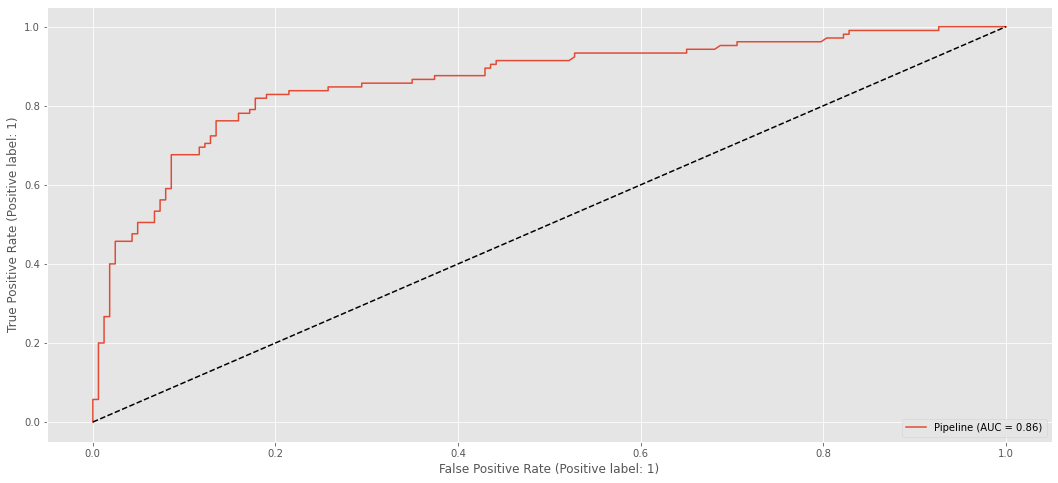

In [21]:
plot_roc_curve(pipe, X_test, y_test)
plot([0, 1], [0, 1], 'k--');

## 7. Competition Submission

In [22]:
df_submission = read_csv("../data/raw/test.csv")
df_submission = df_submission.rename(columns=dict(zip(df_submission.columns, df_submission.columns.str.lower())))
df_submission = df_submission.set_index("passengerid")

In [34]:
str_now = dt.now().strftime("%Y-%m-%d-%H-%M-%S")
DataFrame(
    {
        "PassengerId": df_submission.index,
        "Survived": pipe.predict(df_submission[numerical + categorical])
        }
    ).to_csv(f"../data/processed/{str_now}_submission.csv", index=False)